# R4 - Basic Classifiers and Decision Tree Implementation

This notebook contains implementations for training and evaluating three basic classifiers:
1. **Decision Tree Classifier**
2. **k-Nearest Neighbors (k-NN)**
3. **Naive Bayes Classifier**

It also includes helper functions:
- Methods to load and preprocess data.
- Model evaluation techniques.
- Visualization tools such as plotting the decision tree and confusion matrices.

---

## Importing libraries


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is
import sklearn
assert sklearn.__version__ >= "0.20"

# common imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import for loading data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Import for evaluating models and plotting consusion matrix
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Imports for the models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

---

## Data Loading

This section defines functions for loading preprocessed datasets, including handling categorical variables through One-Hot Encoding and Label Encoding.

In [2]:
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def list_csv_files(directory):
    """
    List all CSV files in the given directory.
    
    Parameters:
    - directory (str): Path to the directory.
    
    Returns:
    - List of CSV filenames.
    """
    return [f for f in os.listdir(directory) if f.endswith('.csv')]

def load_preprocessed_data(base_dir):
    """
    Loads preprocessed training, validation, and test datasets.
    
    Args:
        base_dir (str): Base directory containing the preprocessed datasets.
    
    Returns:
        - X_train (DataFrame): Training features.
        - X_valid (DataFrame): Validation features.
        - X_test (DataFrame): Test features.
        - y_train (Series): Training labels.
        - y_valid (Series): Validation labels.
        - y_test (Series): Test labels.
    """
    # List available CSV files
    available_files = list_csv_files(base_dir)
    
    required_files = ['X_train.csv', 'X_valid.csv', 'X_test.csv', 'y_train.csv', 'y_valid.csv', 'y_test.csv']
    
    # Check if all required files are present
    missing_files = [f for f in required_files if f not in available_files]
    if missing_files:
        raise FileNotFoundError(f"The following required files are missing in {base_dir}: {missing_files}")
    
    # Load preprocessed datasets
    X_train = pd.read_csv(f"{base_dir}/X_train.csv")
    y_train = pd.read_csv(f"{base_dir}/y_train.csv")["target"]
    
    X_valid = pd.read_csv(f"{base_dir}/X_valid.csv")
    y_valid = pd.read_csv(f"{base_dir}/y_valid.csv")["target"]
    
    X_test = pd.read_csv(f"{base_dir}/X_test.csv")
    y_test = pd.read_csv(f"{base_dir}/y_test.csv")["target"]
    
    # Identify categorical columns in features
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # One-Hot Encode categorical features
    if categorical_cols:
        # Apply OneHotEncoder to categorical columns
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        X_train_cat = encoder.fit_transform(X_train[categorical_cols])
        X_valid_cat = encoder.transform(X_valid[categorical_cols])
        X_test_cat = encoder.transform(X_test[categorical_cols])
        
        encoded_cols = encoder.get_feature_names_out(categorical_cols)
        
        # Convert to DataFrame
        X_train_cat = pd.DataFrame(X_train_cat, columns=encoded_cols, index=X_train.index)
        X_valid_cat = pd.DataFrame(X_valid_cat, columns=encoded_cols, index=X_valid.index)
        X_test_cat = pd.DataFrame(X_test_cat, columns=encoded_cols, index=X_test.index)
        
        # Drop original categorical columns and concatenate encoded columns
        X_train = X_train.drop(columns=categorical_cols).reset_index(drop=True)
        X_valid = X_valid.drop(columns=categorical_cols).reset_index(drop=True)
        X_test = X_test.drop(columns=categorical_cols).reset_index(drop=True)
        
        X_train = pd.concat([X_train, X_train_cat], axis=1)
        X_valid = pd.concat([X_valid, X_valid_cat], axis=1)
        X_test = pd.concat([X_test, X_test_cat], axis=1)
    
    # Encode target variable if it's categorical
    if y_train.dtype == 'object' or y_train.dtype.name == 'category':
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)
        y_valid = label_encoder.transform(y_valid)
        y_test = label_encoder.transform(y_test)

    return X_train, X_valid, X_test, y_train, y_valid, y_test


---

## Helper Functions

These helper functions facilitate common tasks like loading data, training models, evaluating performance, and plotting results.

### 1. Training Classifiers

Below are functions to train different classifiers:
- **Decision Tree**
- **k-Nearest Neighbors**
- **Naive Bayes**

In [3]:
# Decision Tree model
def train_decision_tree(X_train, y_train, max_depth=None):
    """
    Trains a Decision Tree classifier.
    
    Args:
        X_train: Training features.
        y_train: Training labels.
        max_depth (int): Maximum depth of the tree. Defaults to None.
    
    Returns:
        model: Trained Decision Tree model.
    """
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    return model

In [4]:
# k-Nearest Neighbors model
def train_knn(X_train, y_train, n_neighbors=5):
    """
    Train a k-NN model with the specified number of neighbors.
    Args: X_train (features), y_train (labels), n_neighbors (number of neighbors to consider).
    
    Returns:
        KNeighborsClassifier: The trained k-NN model.
    """
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    return model

In [5]:
# Naive Bayes model
def train_naive_bayes(X_train, y_train):
    """
    Trains a Gaussian Naïve Bayes classifier with given features and labels.
    
    Returns:
        GaussianNB: The trained Gaussian Naïve Bayes model.
    """
    model = GaussianNB()
    model.fit(X_train, y_train)
    return model

### 2. Model Evaluation function

Evaluates a model and saves the results to a file inside a specific folder.

**Args:**
- model: Trained model.
- X: Features for evaluation
- y: True labels
- model_name (str): Name of the model (for display purposes).
- save_path (str): Path to save the evaluation report.


In [6]:
# Function to evaluate a model
def evaluate_model(model, X, y, model_name, save_path=None):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred)
    
    evaluation_results = f"{model_name} Model Evaluation:\n"
    evaluation_results += f"Accuracy: {accuracy:.4f}\n\n"
    evaluation_results += f"Classification Report:\n{report}\n"
    
    print(evaluation_results)
    
    if save_path:
        with open(save_path, 'w') as f:
            f.write(evaluation_results)
        print(f"{model_name} Model evaluation saved to {save_path}\n")

### 3. Plotting the decision tree

Plots and saves the Decision Tree structure.

**Args:**
- model: Trained Decision Tree model.
- feature_names (list): List of feature names.
- class_names (list): List of class names.
- save_path (str): Path to save the plot (without extension).
- max_depth: Maximum depth to visualize (optional)

In [7]:
# Function to plot the Decision Tree
def plot_decision_tree(model, feature_names, class_names, save_path=None, max_depth=None):
    """
    Plots and saves the Decision Tree structure.
    
    Args:
        model: Trained Decision Tree model.
        feature_names (list): List of feature names.
        class_names (list): List of class names.
        save_path (str): Path to save the plot (without extension).
        max_depth: Maximum depth to visualize (optional)

    Returns:
        None (saves the plot to the specified path).
    """
    fig, ax = plt.subplots(figsize=(26, 10))
    plot_tree(model, 
              feature_names=feature_names, 
              class_names=class_names, 
              max_depth=max_depth, 
              filled=True, 
              fontsize=10,
              ax=ax, 
              rounded=True)
    
    plt.title("Decision Tree Visualization", fontsize=24)
    plt.subplots_adjust(left=0.025, right=0.995, top=0.94, bottom=0)  # Adjust space around the plot
    
    # Save the output plot as PNG file if save_path is provided
    if save_path:
        plt.savefig(f"{save_path}.png")
        print(f"Decision tree plot saved to {save_path}.png")
        
    plt.show()

### 4. Plotting Confusion Matrix

This function visualizes the confusion matrix for the Naive Bayes model's predictions.

In [8]:
def plot_confusion_matrix(y_true, y_pred, class_names, output_path):
    """
    Plot and save the confusion matrix.
    
    Args:
        y_true (pd.Series): True labels.
        y_pred (pd.Series): Predicted labels.
        class_names (list): List of class names.
        output_path (str): Path to save the confusion matrix plot.
    
    Returns:
        None: This function does not return any value. It saves the confusion matrix plot to the specified output path.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cm_display.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title('Confusion Matrix - Naive Bayes')
    plt.savefig(output_path)
    # plt.close()

### 5. Plot KNN model accuracy for different values of k

In [9]:
def plot_knn_accuracy(results, best_k, results_dir, dataset_name):
    k_values = [result[0] for result in results]
    accuracies = [result[1] for result in results]
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
    plt.title(f'Accuracy of k-NN for Different k Values (Best k={best_k})')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Validation Accuracy')
    plt.grid(True)
    knn_plot_path = os.path.join(results_dir, f"{dataset_name}_2.knn_accuracy_plot.png")
    plt.savefig(knn_plot_path)
    print(f"KNN accuracy plot saved to {knn_plot_path}")

### 6. Finding the Best `k` for k-Nearest Neighbors (k-NN)

This function iterates over different values of `k` (from 1 to 20) to determine the one with the highest validation accuracy.


In [10]:
def find_best_k_for_knn(X_train, y_train, X_valid, y_valid):
    """
    Find the best k for k-NN and return the best k and accuracy.
    
    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training labels.
        X_valid (pd.DataFrame): Validation features.
        y_valid (pd.Series): Validation labels.
    
    Returns:
        int: The best k value.
    """
    best_k = None
    best_accuracy = 0
    results = []

    print("\nFinding the best k for k-NN...")
    for k in range(1, 21): # k values from 1 to 20
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_pred)
        results.append((k, accuracy)) # Store the results for each k
        print(f"k={k}: Validation Accuracy = {accuracy:.4f}") # Print the accuracy for each k
        if accuracy > best_accuracy: # Update the best k if the current k is better
            best_k = k
            best_accuracy = accuracy

    return best_k, best_accuracy, results

### 7. Creating Results Directory

A helper function to create directories for saving evaluation results and plots.

In [11]:
def create_results_directory(base_dir: str, dataset_name: str) -> str:
    """
    Create results directory for the specific dataset.
    
    Args:
        base_dir (str): The base directory where the results directory will be created.
        dataset_name (str): The name of the dataset for which the results directory is created.
    
    Returns:
        str: The path to the created results directory.
    """
    script_dir = os.getcwd()  # Get the current working directory
    results_base_dir = os.path.join(script_dir, "R4_Results", dataset_name)
    os.makedirs(results_base_dir, exist_ok=True)
    return results_base_dir

### 8. Model selection and handling functions

In [12]:
# Letting the user choose a model
def get_model_choice():
    print("\nChoose a model to train:")
    print("1. Decision Tree")
    print("2. k-Nearest Neighbors")
    print("3. Naive Bayes")
    choice = input("Enter your choice (1/2/3): ").strip()
    return choice

In [13]:
def handle_decision_tree(X_train, y_train, X_valid, y_valid, results_dir, dataset_name):
    # Train Decision Tree model
    model = train_decision_tree(X_train, y_train, max_depth=10)

    # Visualize the decision tree
    feature_names = list(X_train.columns)
    unique_classes = sorted(set(y_train)) # Get unique classes in the target variable
    class_names = [f'Class {cls}' for cls in unique_classes] # Create class names for the plot
    plot_file_path = os.path.join(results_dir, f"{dataset_name}_1.decision_tree_plot")
    plot_decision_tree(model, feature_names, class_names, plot_file_path, max_depth=3) # Plot the decision tree

    # Save Decision Tree model evaluation to a separate file
    evaluation_output_path = os.path.join(results_dir, f"{dataset_name}_1.decision_tree_model_evaluation.txt")
    evaluate_model(model, X_valid, y_valid, "Decision Tree", evaluation_output_path)

In [14]:
def handle_knn(X_train, y_train, X_valid, y_valid, results_dir, dataset_name):
    # Find the best k for k-NN
    best_k, best_accuracy, results = find_best_k_for_knn(X_train, y_train, X_valid, y_valid)

    # Save best k results
    best_k_path = os.path.join(results_dir, f"{dataset_name}_2.best_k_for_knn.txt")
    with open(best_k_path, 'w') as f:
        f.write(f"Best k: {best_k}\n")
        f.write(f"Validation Accuracy: {best_accuracy:.4f}\n")
        f.write("All k results:\n")
        for k, acc in results:
            f.write(f"k={k}: Validation Accuracy = {acc:.4f}\n")

    print(f"\nBest k value saved to {best_k_path}")

    # Train k-Nearest Neighbors model with the best k (from the range 1-20)
    model = train_knn(X_train, y_train, n_neighbors=best_k)

    # Save KNN model evaluation to a separate file
    evaluation_output_path = os.path.join(results_dir, f"{dataset_name}_2.knn_model_evaluation.txt")
    evaluate_model(model, X_valid, y_valid, "k-Nearest Neighbors", evaluation_output_path)

    # Plot KNN model accuracy for different values of k
    plot_knn_accuracy(results, best_k, results_dir, dataset_name)

In [15]:
def handle_naive_bayes(X_train, y_train, X_valid, y_valid, results_dir, dataset_name):
    # Train Naive Bayes model
    model = train_naive_bayes(X_train, y_train)

    # Save Naive Bayes model evaluation to a separate file
    evaluation_output_path = os.path.join(results_dir, f"{dataset_name}_3.naive_bayes_model_evaluation.txt")
    evaluate_model(model, X_valid, y_valid, "Naive Bayes", evaluation_output_path)

    # Plot confusion matrix for Naive Bayes model
    y_pred = model.predict(X_valid)  # Predict the validation set
    unique_classes = sorted(set(y_train)) # Get unique classes in the target variable
    class_names = [f'Class {cls}' for cls in unique_classes] # Create class names for the plot
    cm_plot_path = os.path.join(results_dir, f"{dataset_name}_3.naive_bayes_confusion_matrix.png")
    plot_confusion_matrix(y_valid, y_pred, class_names, cm_plot_path)

    print(f"Confusion Matrix for Naive Bayes saved to {cm_plot_path}")

---

## Main Program Execution

The main function allows the user to:
1. Select the dataset.
2. Choose a classifier to train.

Then Evaluate and save results using the helper functions

Choose the dataset to load:
1. Delivery Dataset
2. Restaurant Dataset

Choose a model to train:
1. Decision Tree
2. k-Nearest Neighbors
3. Naive Bayes
Decision tree plot saved to /Users/abdallahalshaqra/Desktop/DMML/Dubai_UG-20/CW_progress/Coursework_Code_Files/Basic Classifiers and Decision Trees/R4_Results/delivery/delivery_1.decision_tree_plot.png


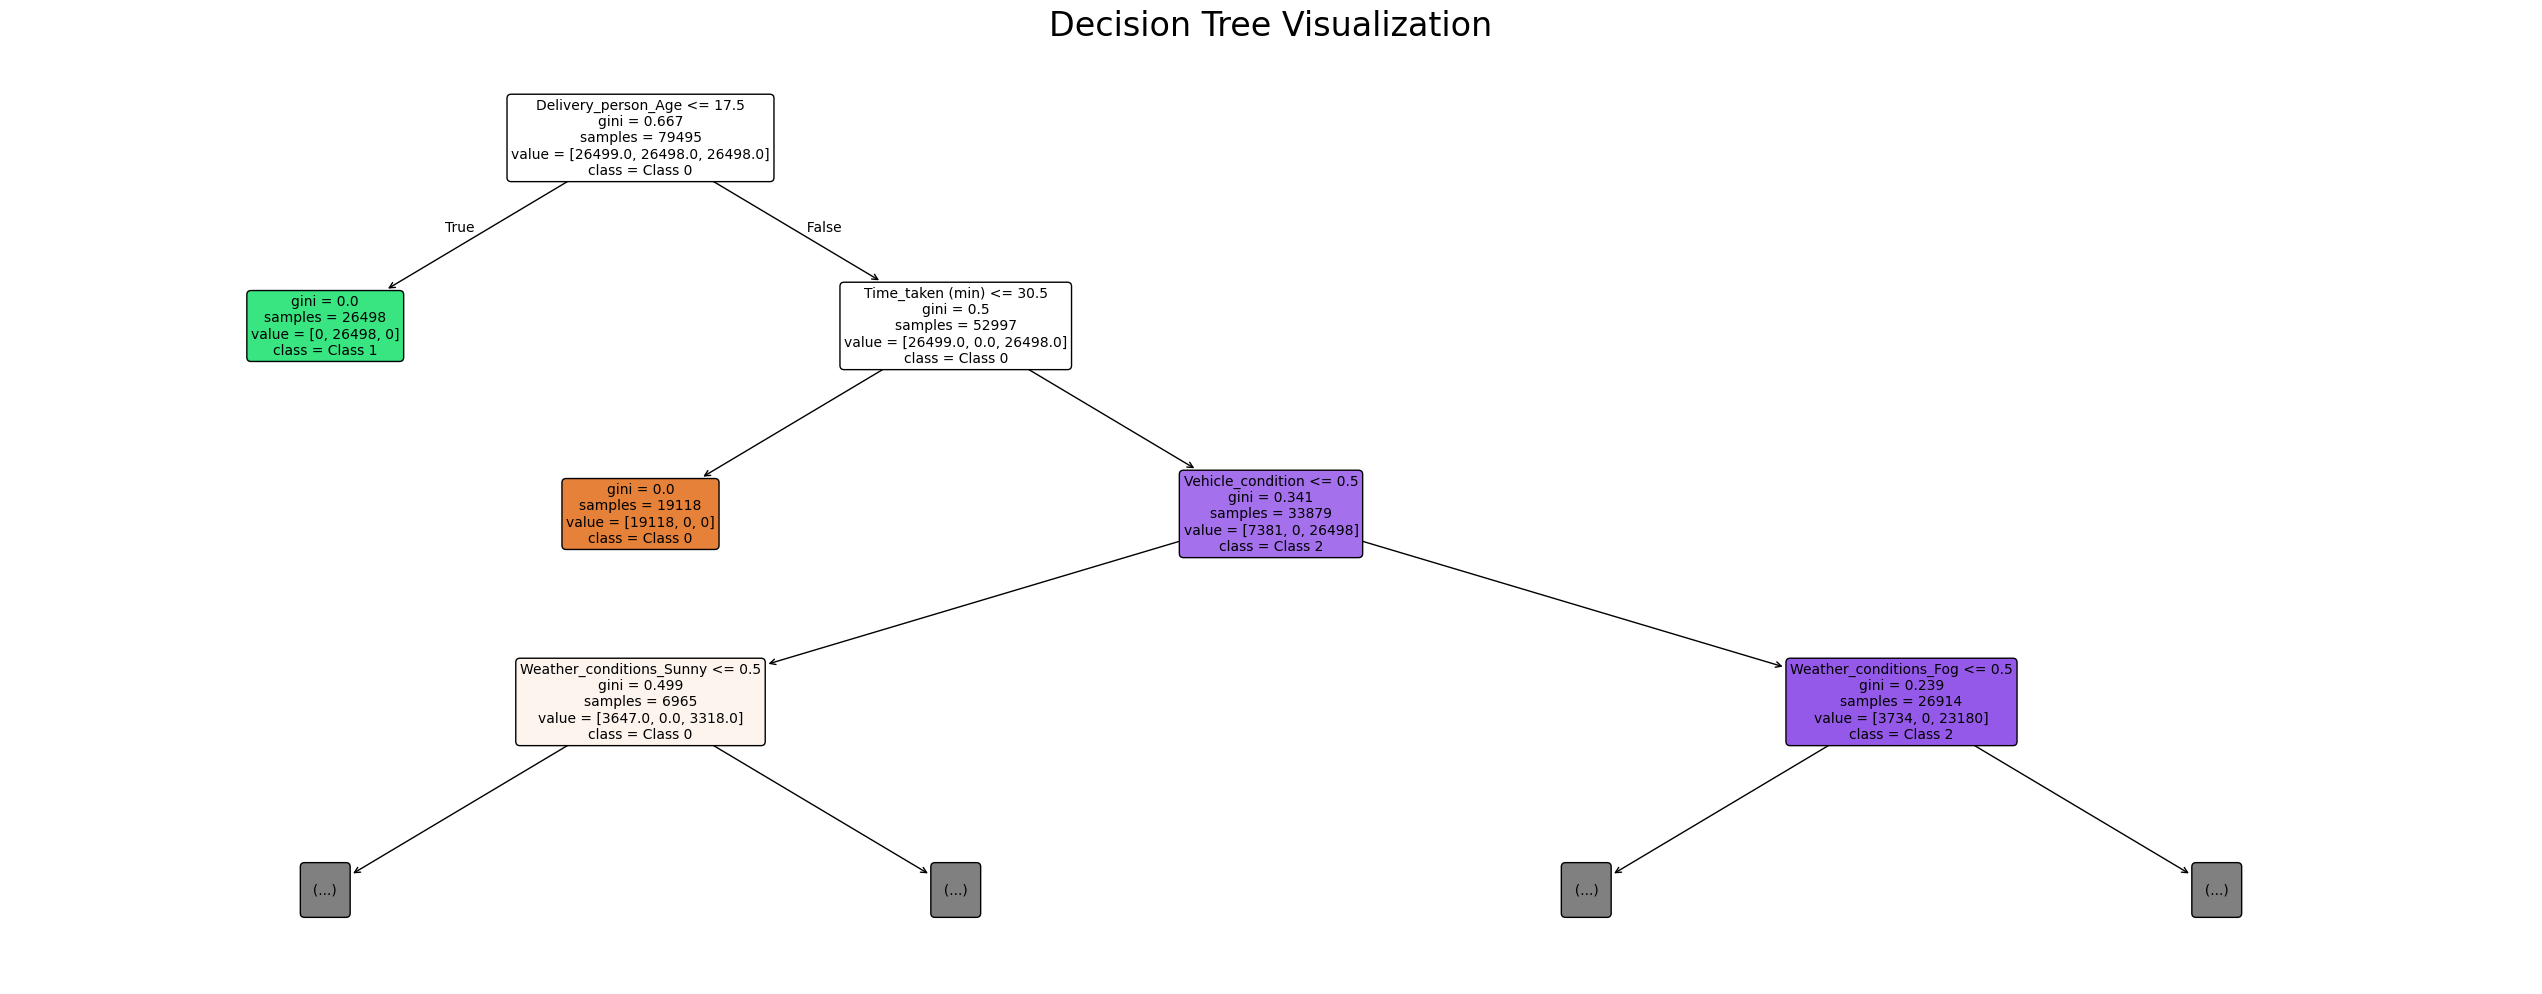

Decision Tree Model Evaluation:
Accuracy: 0.9766

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      8832
           1       1.00      1.00      1.00      8833
           2       0.94      1.00      0.97      8833

    accuracy                           0.98     26498
   macro avg       0.98      0.98      0.98     26498
weighted avg       0.98      0.98      0.98     26498


Decision Tree Model evaluation saved to /Users/abdallahalshaqra/Desktop/DMML/Dubai_UG-20/CW_progress/Coursework_Code_Files/Basic Classifiers and Decision Trees/R4_Results/delivery/delivery_1.decision_tree_model_evaluation.txt



In [16]:
def main():
    # Automatically get the base directory for preprocessed data
    base_dir = os.path.join(os.pardir, 'Datasets', 'preprocessed_data')
    
    # Get the specific data directory from the user
    print("Choose the dataset to load:")
    print("1. Delivery Dataset")
    print("2. Restaurant Dataset")

    choice = input("Enter your choice (1/2): ").strip()
    if choice == '1':
        dataset_dir = os.path.join(base_dir, 'delivery')
    elif choice == '2':
        dataset_dir = os.path.join(base_dir, 'restaurant')
    else:
        print("Invalid choice. Exiting...")
        return
    
    if not os.path.exists(dataset_dir):
        print(f"The directory {dataset_dir} does not exist. Please check your input.")
        return

    # Load preprocessed data
    try:
        X_train, X_valid, X_test, y_train, y_valid, y_test = load_preprocessed_data(dataset_dir)
    except FileNotFoundError as e:
        print(e)
        return
    
    # Extract dataset name from the input directory
    dataset_name = os.path.basename(dataset_dir.rstrip('/'))
    results_dir = create_results_directory(base_dir, dataset_name)

    choice = get_model_choice()
    if choice == '1':
        handle_decision_tree(X_train, y_train, X_valid, y_valid, results_dir, dataset_name)
    
    elif choice == '2':
        handle_knn(X_train, y_train, X_valid, y_valid, results_dir, dataset_name)
    
    elif choice == '3':
        handle_naive_bayes(X_train, y_train, X_valid, y_valid, results_dir, dataset_name)
    
    else:
        print("Invalid choice. Exiting...")
        return

if __name__ == "__main__":
    main()